In [1033]:
import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers
from numpy.random import seed
from numpy import array
from numpy import argmax
from keras import metrics
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [1034]:
file_path_ass = os.path.join("data", "assignment_ds.csv")
file_path_tes = os.path.join("data", "test_ds.csv")
file_path_sam = os.path.join("data", "sample_submission.csv")
data = pd.read_csv(file_path_ass)
data.head()


,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3453,0.000621,0.0773,17.08,Red,M,0
1,12098,689.000000,7.0100,0.02,Blue-white,A,3
2,2731,0.000437,0.0856,18.09,Red,M,0
3,37800,202900.000000,6.8600,-4.56,Blue,O,3
4,8570,0.000810,0.0097,14.20,Blue white,A,2


In [1035]:
seed(10)
df2 = pd.read_csv(file_path_ass)

In [1036]:
df2.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3453,0.000621,0.0773,17.08,Red,M,0
1,12098,689.000000,7.0100,0.02,Blue-white,A,3
2,2731,0.000437,0.0856,18.09,Red,M,0
3,37800,202900.000000,6.8600,-4.56,Blue,O,3
4,8570,0.000810,0.0097,14.20,Blue white,A,2


In [1037]:
pd.set_option("max_rows", None) #To see the dataframe complete

In [1038]:
#Limpieza dataframe
null_columns=df2.columns[df2.isnull().any()] #Returns if there is any null value on the columns
df2[null_columns].isnull().sum()  # This tell us how many null values are in the columns
print(df2[df2.isnull().any(axis=1)][null_columns].head()) # Prints the position of the null value. As we can see, there is no null value in the dataframe

Empty DataFrame
Columns: []
Index: []


In [1039]:
#Colors clean
df2['Color'].unique()
#As we can see, there are colors that are the same but with different name

array(['Red', 'Blue-white', 'Blue', 'Blue white', 'Whitish', 'White',
       'Blue White', 'yellowish', 'white', 'yellow-white',
       'Yellowish White', 'Orange', 'White-Yellow', 'Pale yellow orange',
       'Orange-Red', 'Blue-White', 'Yellowish'], dtype=object)

In [1040]:
# We change the values of the colors so that they could tbe generic
df2['Color'] = df2['Color'].map({'Blue-white':'Blue', 'Blue white':'Blue', 'Blue-White':'Blue', 'Blue White':'Blue', 'Blue':'Blue',
                             'Whitish':'White', 'white':'White','White':'White',
                             'yellowish':'Yellow', 'yellow-white':'Yellow', 'Yellowish White':'Yellow', 'White-Yellow':'Yellow', 'Yellowish':'Yellow','Yellow':'Yellow',
                             'Pale yellow orange':'Orange','Orange':'Orange',
                             'Orange-Red':'Red','Red':'Red'})

In [1041]:
df2['Color'].unique()
#Here he have all the generic colors in the dataframe

array(['Red', 'Blue', 'White', 'Yellow', 'Orange'], dtype=object)

In [1042]:
#Spectral Class in Dataframe
df2['Spectral_Class'].unique()

array(['M', 'A', 'O', 'B', 'K', 'F', 'G'], dtype=object)

In [1043]:
# Now we have to give the colors a value
df2['Color'] = df2['Color'].map({'Blue':1,
                             'White':2,
                             'Yellow':3,
                             'Orange':4,
                             'Red':5})
#Also we have to give a value to the spectral_class
df2['Spectral_Class'] = df2['Spectral_Class'].map({'M':1,
                             'B':2,
                             'O':3,
                             'K':4,
                             'F':5,
                             'A':6,
                             'G':7})
df2.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3453,0.000621,0.0773,17.08,5,1,0
1,12098,689.000000,7.0100,0.02,1,6,3
2,2731,0.000437,0.0856,18.09,5,1,0
3,37800,202900.000000,6.8600,-4.56,1,3,3
4,8570,0.000810,0.0097,14.20,1,6,2


In [1044]:


# shuffle dataset
df2 = df2.sample(frac=1)

# get inputs - outputs
inputs = df2[['Temperature','L','R','A_M','Color','Spectral_Class']]
target = df2[['Type']]
#target2 = df2[['Type']]

Normalize data

In [1045]:
# scale input data
x = inputs.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
inputs = pd.DataFrame(x_scaled)
inputs[0:10]

,0,1,2,3,4,5
0,0.042984,1.448047e-01,0.023090,0.160725,1.0,0.000000
1,0.043772,1.483365e-01,0.576852,0.034709,1.0,0.000000
2,0.703108,1.976643e-02,0.003280,0.244841,0.0,0.166667
3,0.973726,2.401639e-01,0.005436,0.225766,0.0,0.333333
4,0.028980,4.944550e-10,0.000075,0.891807,1.0,0.000000
5,0.017919,6.121824e-10,0.000046,0.773296,1.0,0.000000
6,0.040750,3.178640e-01,0.780086,0.078799,1.0,0.000000
7,0.039227,6.945916e-10,0.000093,0.902439,1.0,0.000000
8,0.017367,3.767276e-10,0.000045,0.916823,1.0,0.000000
9,0.020809,4.202868e-10,0.000040,0.938399,1.0,0.000000


In [1046]:
target.head()

,Type
59,4
5,5
20,3
198,3
52,0


In [1047]:
#integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(target)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
target = pd.DataFrame(onehot_encoded)

target.head()

D:\.Programas\anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


In [1048]:
# define training dataset size
ds_size = inputs.shape[0]
train_size_percentage = .7
test_size_percentage = .2

training_size = int(ds_size * train_size_percentage)
test_size = int(ds_size * test_size_percentage)

# get training data
input_training = inputs[:training_size]
target_training = target[:training_size]

# get test data
input_test = inputs[training_size:(training_size + test_size)]
target_test = target[training_size:(training_size + test_size)]

# get validation data
input_validation = inputs[(training_size + test_size):]
target_validation = target[(training_size + test_size):]

# used during training
print('Training DS size:', input_training.shape[0])
print('Test DS size:', input_test.shape[0])

# used during validation
print('Validation DS size', input_validation.shape[0])

Training DS size: 140
Test DS size: 40
Validation DS size 20


In [1049]:
print('inputs:')
print(inputs[:10])
print('target')
target[:10]

inputs:
          0             1         2         3    4         5
0  0.042984  1.448047e-01  0.023090  0.160725  1.0  0.000000
1  0.043772  1.483365e-01  0.576852  0.034709  1.0  0.000000
2  0.703108  1.976643e-02  0.003280  0.244841  0.0  0.166667
3  0.973726  2.401639e-01  0.005436  0.225766  0.0  0.333333
4  0.028980  4.944550e-10  0.000075  0.891807  1.0  0.000000
5  0.017919  6.121824e-10  0.000046  0.773296  1.0  0.000000
6  0.040750  3.178640e-01  0.780086  0.078799  1.0  0.000000
7  0.039227  6.945916e-10  0.000093  0.902439  1.0  0.000000
8  0.017367  3.767276e-10  0.000045  0.916823  1.0  0.000000
9  0.020809  4.202868e-10  0.000040  0.938399  1.0  0.000000
target


,0,1,2,3,4,5
0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,1.0
7,1.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0



Train Neural Network 

Define Neural Network Architecture

In [1077]:
# neural network
model = models.Sequential()

# input layer
model.add(layers.Dense(32, activation='relu', input_shape=(6,)))

# hidden layers
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
#Aditional layer added

# output layers
model.add(layers.Dense(6, activation='sigmoid'))
    
rmsprop = optimizers.RMSprop(learning_rate=0.01)
#learning_rate changed from 0.1 to 0.01
model.compile(optimizer=rmsprop, loss='mse', metrics=[metrics.categorical_accuracy])

In [1078]:
#Cambiar labels de las columnas

In [1079]:
num_epochs = 250
batch_size = 64

history = model.fit(input_training, target_training,
                            validation_data=(input_test, target_test),
                            epochs=num_epochs, batch_size=batch_size, verbose=1)

Epoch 1/250
3/3 [==============================] - 0s 48ms/step - loss: 0.2421 - categorical_accuracy: 0.1857 - val_loss: 0.2067 - val_categorical_accuracy: 0.1750
Epoch 2/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1961 - categorical_accuracy: 0.2500 - val_loss: 0.1779 - val_categorical_accuracy: 0.1750
Epoch 3/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1630 - categorical_accuracy: 0.2643 - val_loss: 0.1505 - val_categorical_accuracy: 0.2250
Epoch 4/250
3/3 [==============================] - 0s 8ms/step - loss: 0.1432 - categorical_accuracy: 0.2714 - val_loss: 0.1407 - val_categorical_accuracy: 0.1500
Epoch 5/250
3/3 [==============================] - 0s 9ms/step - loss: 0.1327 - categorical_accuracy: 0.2643 - val_loss: 0.1240 - val_categorical_accuracy: 0.3250
Epoch 6/250
3/3 [==============================] - 0s 9ms/step - loss: 0.1223 - categorical_accuracy: 0.3571 - val_loss: 0.1180 - val_categorical_accuracy: 0.4000
Epoch 7/250
3/3 [====

Epoch 51/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0293 - categorical_accuracy: 0.8500 - val_loss: 0.0189 - val_categorical_accuracy: 0.9750
Epoch 52/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0248 - categorical_accuracy: 0.9071 - val_loss: 0.0502 - val_categorical_accuracy: 0.7500
Epoch 53/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0293 - categorical_accuracy: 0.8714 - val_loss: 0.0214 - val_categorical_accuracy: 0.9750
Epoch 54/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0220 - categorical_accuracy: 0.9571 - val_loss: 0.0237 - val_categorical_accuracy: 0.9500
Epoch 55/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0286 - categorical_accuracy: 0.8786 - val_loss: 0.0312 - val_categorical_accuracy: 0.8500
Epoch 56/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0253 - categorical_accuracy: 0.9071 - val_loss: 0.0288 - val_categorical_accuracy: 0.9250
Epoch 57/250
3/3

Epoch 101/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0357 - categorical_accuracy: 0.8571 - val_loss: 0.0058 - val_categorical_accuracy: 0.9750
Epoch 102/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0172 - categorical_accuracy: 0.9143 - val_loss: 0.0033 - val_categorical_accuracy: 1.0000
Epoch 103/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0160 - categorical_accuracy: 0.9143 - val_loss: 0.0048 - val_categorical_accuracy: 1.0000
Epoch 104/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0042 - categorical_accuracy: 1.0000 - val_loss: 0.0027 - val_categorical_accuracy: 1.0000
Epoch 105/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0043 - categorical_accuracy: 1.0000 - val_loss: 0.0114 - val_categorical_accuracy: 0.9750
Epoch 106/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0078 - categorical_accuracy: 0.9857 - val_loss: 0.0077 - val_categorical_accuracy: 0.9500
Epoch 107/

Epoch 151/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 0.0044 - val_categorical_accuracy: 0.9750
Epoch 152/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0250 - categorical_accuracy: 0.8929 - val_loss: 0.0042 - val_categorical_accuracy: 0.9750
Epoch 153/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0021 - categorical_accuracy: 0.9929 - val_loss: 0.0064 - val_categorical_accuracy: 0.9750
Epoch 154/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0057 - categorical_accuracy: 0.9714 - val_loss: 0.0031 - val_categorical_accuracy: 0.9750
Epoch 155/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0217 - categorical_accuracy: 0.9000 - val_loss: 0.0025 - val_categorical_accuracy: 1.0000
Epoch 156/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0079 - categorical_accuracy: 0.9643 - val_loss: 0.0223 - val_categorical_accuracy: 0.9250
Epoch 157/

3/3 [==============================] - 0s 9ms/step - loss: 5.2093e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0098 - val_categorical_accuracy: 0.9500
Epoch 201/250
3/3 [==============================] - 0s 8ms/step - loss: 9.1914e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0059 - val_categorical_accuracy: 0.9750
Epoch 202/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0256 - categorical_accuracy: 0.9071 - val_loss: 0.0024 - val_categorical_accuracy: 1.0000
Epoch 203/250
3/3 [==============================] - 0s 9ms/step - loss: 5.6164e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0022 - val_categorical_accuracy: 1.0000
Epoch 204/250
3/3 [==============================] - 0s 8ms/step - loss: 0.0032 - categorical_accuracy: 0.9857 - val_loss: 0.0330 - val_categorical_accuracy: 0.8750
Epoch 205/250
3/3 [==============================] - 0s 9ms/step - loss: 0.0159 - categorical_accuracy: 0.9500 - val_loss: 3.9729e-04 - val_categorical_accuracy: 1.0000
Epoch 20

Epoch 249/250
3/3 [==============================] - 0s 8ms/step - loss: 5.5217e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0014 - val_categorical_accuracy: 1.0000
Epoch 250/250
3/3 [==============================] - 0s 9ms/step - loss: 2.1007e-04 - categorical_accuracy: 1.0000 - val_loss: 0.0025 - val_categorical_accuracy: 1.0000


In [1080]:
epochs = range(1, num_epochs+1)

# during training
loss = history.history['loss']
accuracy = history.history['categorical_accuracy']

# outside training
val_loss = history.history['val_loss']
val_accuracy = history.history['val_categorical_accuracy']

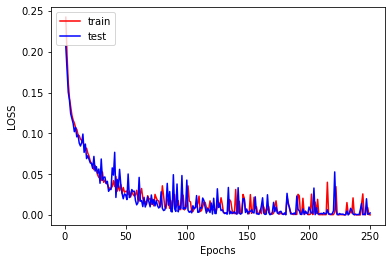

In [1081]:
# plot loss
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#AUMENTAR NUM EPOCHS

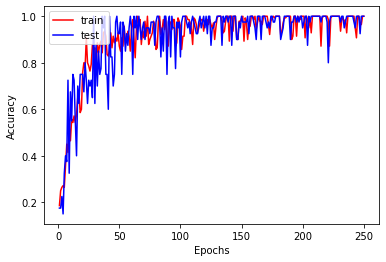

In [1082]:
# plot accuracy
plt.plot(epochs, accuracy, 'r')
plt.plot(epochs, val_accuracy, 'b')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Validate

In [1083]:
#predict
predictions_targets = model.predict(input_validation)
predicted = label_encoder.inverse_transform(predictions_targets.argmax(1))

In [1084]:
# target
targets_val = label_encoder.inverse_transform(np.array(target_validation.values).argmax(1))

In [1085]:
# compare them
df = pd.DataFrame({'target':targets_val, 'predicted': predicted})
df

,target,predicted
0,5,5
1,1,1
2,0,0
3,3,3
4,1,1
5,5,5
6,5,5
7,4,4
8,0,0
9,4,4


applying to the test

In [1086]:
df3 = pd.read_csv(file_path_tes)
df3['Color'] = df3['Color'].map({'Blue-white':'Blue', 'Blue white':'Blue', 'Blue-White':'Blue', 'Blue White':'Blue', 'Blue':'Blue',
                             'Whitish':'White', 'white':'White','White':'White',
                             'yellowish':'Yellow', 'yellow-white':'Yellow', 'Yellowish White':'Yellow', 'White-Yellow':'Yellow', 'Yellowish':'Yellow','Yellow':'Yellow',
                             'Pale yellow orange':'Orange','Orange':'Orange',
                             'Orange-Red':'Red','Red':'Red'})
df3['Color'] = df3['Color'].map({'Blue':1,
                             'White':2,
                             'Yellow':3,
                             'Orange':4,
                             'Red':5})
#Also we have to give a value to the spectral_class
df3['Spectral_Class'] = df3['Spectral_Class'].map({'M':1,
                             'B':2,
                             'O':3,
                             'K':4,
                             'F':5,
                             'A':6,
                             'G':7})
df3.head()

,Temperature,L,R,A_M,Color,Spectral_Class
0,21020,0.00150,0.0112,11.52,1,2
1,2935,0.00087,0.0932,16.88,5,1
2,16390,1278.00000,5.6800,-3.32,1,2
3,3628,0.00550,0.3930,10.48,5,1
4,3496,0.00125,0.3360,14.94,5,1


In [1087]:

# shuffle dataset
#df3 = df3.sample(frac=1)

# get inputs
inputs = df3[['Temperature','L','R','A_M','Color','Spectral_Class']]

# scale input data
x = inputs.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
inputs = pd.DataFrame(x_scaled)
inputs[0:10]
predicted_classes = model.predict(inputs)
predicted_classes = np.argmax(np.round(predicted_classes), axis = 1)
predicted_classes

array([2, 0, 3, 1, 1, 1, 3, 5, 5, 2, 4, 2, 3, 0, 0, 4, 2, 5, 1, 4, 1, 5,
       4, 4, 0, 1, 0, 5, 3, 4, 3, 3, 0, 5, 0, 1, 4, 0, 0], dtype=int64)

In [1088]:
predicted_classes = model.predict(inputs)
predicted_classes = np.argmax(np.round(predicted_classes), axis = 1)
predicted_classes

array([2, 0, 3, 1, 1, 1, 3, 5, 5, 2, 4, 2, 3, 0, 0, 4, 2, 5, 1, 4, 1, 5,
       4, 4, 0, 1, 0, 5, 3, 4, 3, 3, 0, 5, 0, 1, 4, 0, 0], dtype=int64)

In [1089]:
#Revisar como evaluar la prueba

In [1090]:
df4 = pd.read_csv(file_path_sam)
df4Id = df4['Id']
df4

,Id,Type
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [1091]:
#df4 = df4.drop(['Id'], axis=1)
df4.shape

(39, 2)

In [1092]:
df4 = pd.DataFrame({'Id':df4Id,'Type': predicted_classes})
df4
df4.to_csv("submission.csv", index=False)